In [1]:
import numpy as np
import matplotlib.pyplot as plt
import saqqara
from simulator import LISA_AET
import glob
import torch
import swyft
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from pytorch_lightning import loggers as pl_loggers

/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Find data files and check them

In [2]:
DATA_DIR = "./simulations/"
Z_FILES = glob.glob(DATA_DIR + "/z_*.npy")
Z_FILES = sorted(Z_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
DATA_FILES = glob.glob(DATA_DIR + "/cg_data_*.npy")
DATA_FILES = sorted(DATA_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))

# Check all names match
for idx in range(len(Z_FILES)):
    assert (
        Z_FILES[idx].split("_")[-1].split(".")[0]
        == DATA_FILES[idx].split("_")[-1].split(".")[0]
    )

# Compute total number of simulations
n_simulations = len(Z_FILES) * 128
print(f"Total number of simulations: {n_simulations}")

# Get data shapes
z_shape = np.load(Z_FILES[0]).shape[1:]
data_shape = np.load(DATA_FILES[0]).shape[1:]
print(f"z shape: {z_shape}")
print(f"data shape: {data_shape}")

Total number of simulations: 478464
z shape: (4,)
data shape: (945, 3)


### Load simulator and config

In [3]:
config = saqqara.load_settings("default_config.yaml")
sim = LISA_AET(config)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


### Construct datasets and dataloaders

In [4]:
z_dataset = saqqara.NPYDataset(file_paths=Z_FILES)
data_dataset = saqqara.NPYDataset(file_paths=DATA_FILES)

In [5]:
# Check the dataset loading
z_batch = z_dataset[:100]
data_batch = data_dataset[:100]
print("z_batch shape:", z_batch.shape)
print("data_batch shape:", data_batch.shape)

z_batch shape: torch.Size([100, 4])
data_batch shape: torch.Size([100, 945, 3])


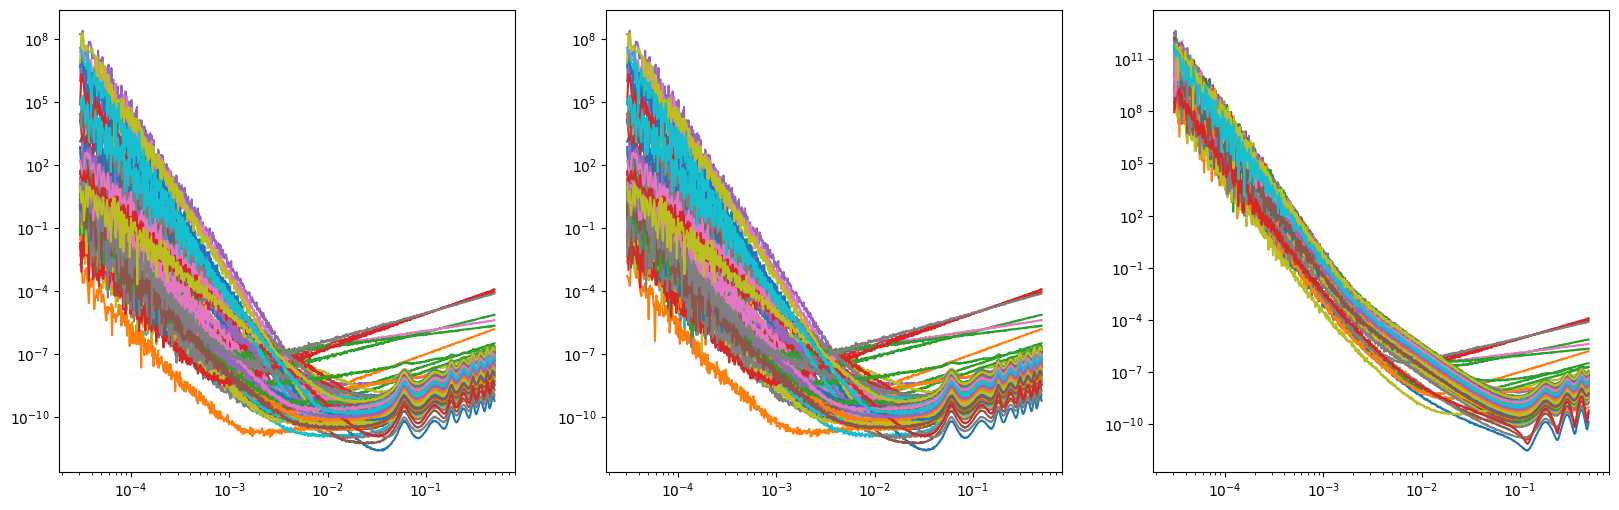

In [6]:
fig = plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.loglog(sim.coarse_grained_f, data_batch[:, :, i].T)

In [7]:
training_dataset = saqqara.TrainingDataset(z_store=z_dataset, data_store=data_dataset)

In [8]:
# Dataset properties
print("Training dataset properties:")
print("length:", len(training_dataset))
print("z shape:", training_dataset["z"][0].shape)
print("data shape:", training_dataset["data"][0].shape)

Training dataset properties:
length: 478464
z shape: torch.Size([4])
data shape: torch.Size([945, 3])


/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/saqqara/data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return torch.from_numpy(data).float()


In [9]:
def setup_dataloaders(
    dataset,
    total_size=None,
    train_fraction=0.8,
    val_fraction=0.2,
    num_workers=0,
    batch_size=64,
):
    if total_size is None:
        total_size = len(dataset)
    indices = list(range(len(dataset)))
    train_idx, val_idx = int(np.floor(train_fraction * total_size)), int(
        np.floor((train_fraction + val_fraction) * total_size)
    )
    train_indices, val_indices = indices[:train_idx], indices[train_idx:val_idx]
    # train_sampler, val_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    train_sampler, val_sampler = SequentialSampler(train_indices), SequentialSampler(
        val_indices
    )
    train_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=train_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    val_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=val_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    return train_dataloader, val_dataloader

In [15]:
train_dl, val_dl = setup_dataloaders(training_dataset, total_size=20_000, num_workers=0, batch_size=64)

In [16]:
for batch in train_dl:
    log_data = torch.log(batch["data"])
    print(log_data.transpose(1, 2).shape)
    break

torch.Size([64, 3, 945])


### Setup networks and trainer

In [12]:
from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel


class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, sim=None):
        super().__init__()
        self.sim = sim
        self.learning_rate = 1e-4
        self.num_feat_param = 3  # Number of channels
        self.num_params = 4
        self.npts = sim.coarse_grained_f.shape[0]
        self.nl_AA = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT = OnlineStandardizingLayer(shape=(self.npts,))
        self.resnet = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=4,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.fc_AA = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_EE = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_TT = torch.nn.Linear(self.npts, sim.nparams)
        self.marginals = self.get_marginals(sim.nparams)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            num_features=self.num_feat_param,
            num_params=self.num_params,
            varnames="z",
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            num_features=2 * self.num_feat_param,
            marginals=self.marginals,
            varnames="z",
        )

    def forward(self, A, B):
        log_data = torch.log(A["data"])
        # reshape to (batch, num_channels, num_freqs)
        log_data = log_data.transpose(1, 2)
        norm_AA = self.nl_AA(log_data[..., 0, :])
        norm_EE = self.nl_EE(log_data[..., 1, :])
        norm_TT = self.nl_TT(log_data[..., 2, :])

        full_data = torch.stack([norm_AA, norm_EE, norm_TT], dim=-2)

        compression = self.resnet(full_data)
        s1 = compression.reshape(
            -1, self.num_params, self.num_feat_param
        )  # (batch, num_params, num_feat_param)
        s2 = torch.stack(
            [torch.cat([s1[:, i, :], s1[:, j, :]], dim=-1) for i, j in self.marginals],
            dim=1,
        )
        lrs1d = self.lrs1d(s1, B["z"])
        lrs2d = self.lrs2d(s2, B["z"])
        return lrs1d, lrs2d

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)

In [17]:
logger = pl_loggers.WandbLogger(
    offline=False,
    name="test",
    project="saqqara",
    entity="j-b-g-alvey",
    log_model="all",
    config=config,
)
trainer = swyft.SwyftTrainer(accelerator="cpu", max_epochs=1, logger=logger)
network = InferenceNetwork(sim=sim)

/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [18]:
trainer.fit(network, train_dl, val_dl)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name   | Type                     | Params
----------------------------------------------------
0 | nl_AA  | OnlineStandardizingLayer | 0     
1 | nl_EE  | OnlineStandardizingLayer | 0     
2 | nl_TT  | OnlineStandardizingLayer | 0     
3 | resnet | ResidualNetWithChannel   | 285 K 
4 | fc_AA  | Linear                   | 3.8 K 
5 | fc_EE  | Linear                   | 3.8 K 
6 | fc_TT  | Linear                   | 3.8 K 
7 | lrs1d  | LogRatioEstimator_1dim   | 70.1 K
8 | lrs2d  | LogRatioEstimator_Ndim   | 106 K 
----------------------------------------------------
473 K     Trainable params
0         Non-trainable params
473 K     Total params
1.894     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 312/312 [01:37<00:00,  3.20it/s, loss=-9.05, v_num=z40o, val_loss=-8.89]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 312/312 [01:38<00:00,  3.16it/s, loss=-9.05, v_num=z40o, val_loss=-8.89]
Reloading best model: ./saqqara/1zfgz40o/checkpoints/epoch=0-step=250.ckpt
